# Dataset description
### NIH Chest X-ray Dataset

<h2> Problem </h2>

Chest X-ray exams are among the most commonly conducted and least expensive imaging procedures available today.
However, the clinical diagnosis of a chest radiograph is complicated and often more complex than a chest CT scan.
To a large degree, clinical identification and evaluation is yet unachievable due to the lack of widely accessible datasets for chest X-rays. Once you have a huge dataset of X-ray files, you're usually left lacking in resources to mark it.
Prior to the availability of this dataset, the number of publicly accessible X-ray images was 4,143.

This NIH dataset consist of 112,120 disease labels from 3,805 unique patients with size 1024 x 1024.

Image labels may contain some inaccuracies, but the estimated NLP labeling accuracy is determined to be higher than 90%.


**BBox_list_2017.csv: **Bounding box coordinates. Note: Start at x,y, extend horizontally w pixels, and vertically h pixels

- Image Index: File name
- Finding Label: Disease type (Class label)
- Bbox x
- Bbox y
- Bbox w
- Bbox h


**Data_entry_2020.csv:** Class labels and patient data for the entire dataset
- Image Index: File name
- Finding Labels: Disease type (Class label)
- Follow-up #
- Patient ID
- Patient Age
- Patient Gender
- View Position: X-ray orientation
- OriginalImageWidth
- OriginalImageHeight
- OriginalImagePixelSpacing_x
- OriginalImagePixelSpacing_y


**Class descriptions**

There are 15 classes (14 diseases, and one for "No findings" or normal). Images can be classified as "No findings" or one or more disease classes:

- Atelectasis
- Consolidation
- Infiltration
- Pneumothorax
- Edema
- Emphysema
- Fibrosis
- Effusion
- Pneumonia
- Pleural_thickening
- Cardiomegaly
-  Nodule Mass
-  Hernia


# Importing the libraries

In [1]:
import pandas as pd
from itertools import chain
import numpy as np
import tensorflow as tf 
import matplotlib.pyplot as plt

# Classes

In [2]:
class Info_Class:
    def __init__(self, pathologies, class_weights, target_size, steps_per_epoch, validation_steps):
        self.pathologies      = pathologies
        self.class_weights    = class_weights
        self.target_size      = target_size
        self.steps_per_epoch  = steps_per_epoch
        self.validation_steps = validation_steps

## Reading the csv tables

In [3]:
# dir = '/Users/artinmac/GoogleDrive/RESEARCH/projects/Data7.chest_xray'
dir = '/groups/jjrodrig/projects/chest/dataset/nih'

all_data       = pd.read_csv(dir + '/files/Data_Entry_2017_v2020.csv')
test_list      = pd.read_csv(dir + '/files/test_list.txt',names=['Image Index'])

all_data.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,0.171
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,0.168


In [4]:
all_data.describe()

,Follow-up #,Patient ID,Patient Age,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
count,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000
mean,8.573751,14346.381743,46.626365,2646.078844,2486.438842,0.155649,0.155649
std,15.406320,8403.876972,16.602680,341.246429,401.268227,0.016174,0.016174
min,0.000000,1.000000,0.000000,1143.000000,966.000000,0.115000,0.115000
25%,0.000000,7310.750000,34.000000,2500.000000,2048.000000,0.143000,0.143000
50%,3.000000,13993.000000,49.000000,2518.000000,2544.000000,0.143000,0.143000
75%,10.000000,20673.000000,59.000000,2992.000000,2991.000000,0.168000,0.168000
max,183.000000,30805.000000,95.000000,3827.000000,4715.000000,0.198800,0.198800


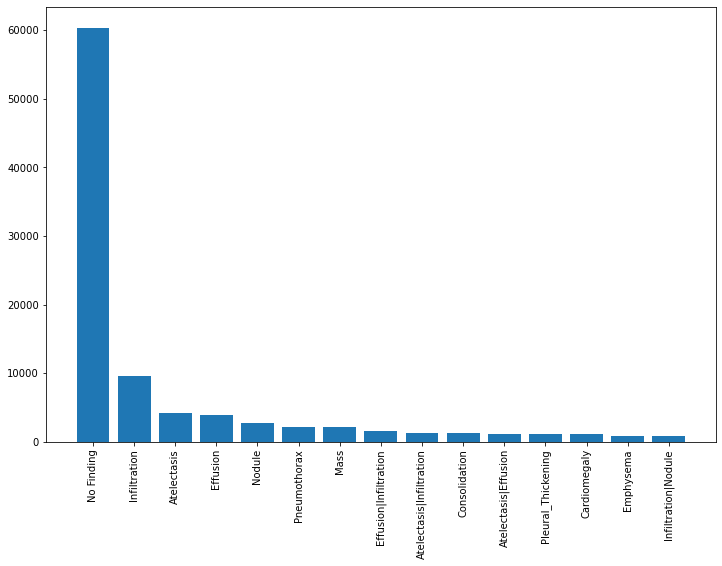

In [5]:
label_counts = all_data['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

## Writing the relative path

In [6]:
all_data['Path'] = all_data['Image Index'].map(lambda x: 'data/' + x)

## Finding the list of all studied pathologies

In [7]:
all_data['Finding Labels'] = all_data['Finding Labels'].replace('No Finding','normal').map(lambda x: x.split('|'))
pathologies = set(list(chain(*all_data['Finding Labels'])))
# pathologies.discard('')   

## Overwriting the order of pathologeis

In [8]:
pathologies = ['normal', 'Pneumonia', 'Mass', 'Pneumothorax', 'Pleural_Thickening', 'Edema', 'Cardiomegaly', 'Emphysema', 'Effusion', 'Consolidation', 'Nodule', 'Infiltration', 'Atelectasis', 'Fibrosis']

## Creating the pathology based columns

In [9]:
for name in pathologies:
    all_data[name] = all_data['Finding Labels'].map(lambda x: 1 if name in x else 0)

## Creating the disease vectors

In [10]:
all_data['disease_vector'] = all_data[pathologies].values.tolist()
all_data['disease_vector'] = all_data['disease_vector'].map(lambda x: np.array(x))  
   

In [11]:
all_data['disease_vector'].iloc[0]

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

## Removing unnecessary columns

In [12]:
all_data = all_data.drop(columns=['OriginalImage[Width', 'Height]', 'OriginalImagePixelSpacing[x',	'y]', 'Follow-up #'])

## Selecting the pathologies with at least a minimum number of samples

In [13]:
# MIN_CASES = 1000
# pathologies = [name for name in pathologies if all_data[name].sum()>MIN_CASES]
# print('Number of samples per class ({})'.format(len(pathologies)), 
#     [(name,int(all_data[name].sum())) for name in pathologies])

## Resampling the dataset to make class occurrences more reasonable

In [14]:
CASE_NUMBERS = 800
sample_weights = all_data['Finding Labels'].map(lambda x: len(x) if len(x)>0 else 0).values + 4e-2
sample_weights /= sample_weights.sum()
all_data = all_data.sample(CASE_NUMBERS, weights=sample_weights)

## Separating train validation test

In [15]:

test      = all_data[all_data['Image Index'].isin(test_list['Image Index'])]
train_val = all_data.drop(test.index)

valid     = train_val.sample(frac=0.2)
train     = train_val.drop(valid.index)

print('train size:',train.shape)
print('valid size:',valid.shape)
print('test size:' ,test.shape)

L = len(pathologies)
class_weights = np.ones(L)/L
    

train size: (474, 22)
valid size: (119, 22)
test size: (207, 22)


In [16]:
train.head()

,Image Index,Finding Labels,Patient ID,Patient Age,Patient Gender,View Position,Path,normal,Pneumonia,Mass,...,Edema,Cardiomegaly,Emphysema,Effusion,Consolidation,Nodule,Infiltration,Atelectasis,Fibrosis,disease_vector
105346,00028300_001.png,[normal],28300,16,M,AP,data/00028300_001.png,1,0,0,...,0,0,0,0,0,0,0,0,0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
50865,00012864_005.png,"[Consolidation, Nodule]",12864,48,M,PA,data/00012864_005.png,0,0,0,...,0,0,0,0,1,1,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0]"
80296,00019733_001.png,"[Atelectasis, Hernia]",19733,69,M,PA,data/00019733_001.png,0,0,0,...,0,0,0,0,0,0,0,1,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
36214,00009566_000.png,[normal],9566,50,F,PA,data/00009566_000.png,1,0,0,...,0,0,0,0,0,0,0,0,0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
45859,00011741_002.png,[normal],11741,16,M,PA,data/00011741_002.png,1,0,0,...,0,0,0,0,0,0,0,0,0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


# Keras Genearator

In [17]:
generator = tf.keras.preprocessing.image.ImageDataGenerator()

target_size =  (224,224) # (64,64)  #
class_mode='raw'
color_mode = 'rgb'
y_col = list(pathologies) #'disease_vector'
batch_size=30

## Train/Validation

In [18]:
train_generator = generator.flow_from_dataframe(dataframe=train, x_col='Path', y_col=y_col,color_mode=color_mode,directory=dir, target_size=target_size, batch_size=10000, class_mode=class_mode, shuffle=False)

valid_generator = generator.flow_from_dataframe(dataframe=valid, x_col='Path', y_col=y_col,color_mode=color_mode,directory=dir, target_size=target_size, batch_size=10000, class_mode=class_mode, shuffle=False)  

(x_train, y_train) = next(train_generator)
steps_per_epoch = int(x_train.shape[0]/batch_size)
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().batch(batch_size)


(x_valid, y_valid) = next(valid_generator)
validation_steps = int(x_valid.shape[0]/batch_size)
valid_data = tf.data.Dataset.from_tensor_slices((x_valid, y_valid)) 
valid_data = valid_data.repeat().batch(batch_size)

Info = Info_Class(pathologies, class_weights, target_size, steps_per_epoch, validation_steps)

Found 474 validated image filenames.
Found 119 validated image filenames.


## Test

In [19]:
test_generator = generator.flow_from_dataframe(dataframe=test, x_col='Path', y_col=y_col,color_mode=color_mode,directory=dir, target_size=target_size, batch_size=1, class_mode=class_mode, shuffle=False)

Info = Info_Class(pathologies, class_weights, target_size, '', '')

Found 207 validated image filenames.
